---

<h1 style="text-align: center;font-size: 40px;">Ocular Disease Recognition using InceptionV3， EfficientNet and Vgg16</h1>

---

<h3>Dataset Information:</h3>
Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions.Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

- Normal (N),
- Diabetes (D),
- Glaucoma (G),
- Cataract (C)

###**Import libraries**

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from mlxtend.plotting import plot_confusion_matrix
from google.colab import drive
import os  # Importing the os module
from imblearn.over_sampling import SMOTE  # For oversampling

## **Data Input**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define dataset directory and classes
dataset_dir = "/content/drive/MyDrive/archive(V2)/preprocessed_images"
classes = ['N', 'D', 'G', 'C']
class_to_label = {cls: idx for idx, cls in enumerate(classes)}

# Read data
df = pd.read_csv("/content/drive/MyDrive/archive(V2)/full_df.csv")


## **Data Information and Checking**

In [ ]:
df_eda = df.copy()
df_eda.head()

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1   
4  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
3  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
4  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   

                     target     filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg  
2  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg  
3  [0, 1, 0, 0, 0, 0, 0, 0]  4_right.jpg  
4  [0, 1, 0, 0, 0, 0, 0, 0]  5_right.jpg

In [ ]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

check duplicate value

In [ ]:
len(df_eda[df_eda.duplicated()])

0

check missing value

In [ ]:
df_eda.isnull().sum().sum()

0

In [ ]:
df_eda['labels'].value_counts()

labels
['N']    2873
['D']    1608
['O']     708
['C']     293
['G']     284
['A']     266
['M']     232
['H']     128
Name: count, dtype: int64

## **Exploratory Data Analysis**

In [ ]:
import re

df_eda["class"] = df_eda["labels"].apply(lambda x: " ".join(re.findall("[a-zA-Z]+", x)))

In [ ]:
labels_long = ["Normal", "Diabetes", "Glaucoma", "Cataract", "AMD", "Hypertension", "Myopia", "Other"]
labels_short = [ll[0] for ll in labels_long]

class_short2full = {
    ls: ll
    for ls, ll in zip(labels_short, labels_long)
}

class_dict = {class_ : i for i, class_ in enumerate(class_short2full.keys())}
class_dict_rev = {v: k for k, v in class_dict.items()}

NUM_CLASSES = len(class_dict)

In [ ]:
import matplotlib as mpl

SEED = 42

COLORS = {
    "fig_bg": "#f6f5f5",
    "plot_neut": "#ddbea9",
    "plot_text": "#343a40",

    "cmap_color_list": ["#001219", "#005F73", "#0A9396", "#94D2BD", "#E9D8A6",
                        "#EE9B00", "#CA6702", "#BB3E03", "#AE2012", "#9B2226"],

    "split": {
        "train": "#264653",
        "val": "#2a9d8f",
        "test": "#e9c46a"
    }
}

COLORS["class"] = {ls: c for ls, c in zip(class_short2full.keys(), COLORS["cmap_color_list"][:len(class_short2full.keys())])}
COLORS["cmap"] = mpl.colors.LinearSegmentedColormap.from_list("", COLORS["cmap_color_list"])
COLORS["cmap_pos"] = mpl.colors.LinearSegmentedColormap.from_list("", ["#F0F3F8", "#D1DBE9", "#A2B7D2", "#7493BC", "#6487B4", "#3D5A80"])

colors_class_list = list(COLORS["class"].values())

FONT_KW = {
    "plot_title" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "25",
        "style": "normal"
    },
    "plot_title_small" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "16",
        "style": "normal"
    },
    "plot_subtitle" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "12",
        "style": "normal"
    },
    "subplot_title" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "18",
        "style": "normal"
    },
    "subplot_title_small" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "12",
        "style": "normal"
    },
    "plot_label" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "16",
        "style": "normal"
    },
    "plot_label_small" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "12",
        "style": "normal"
    },
    "plot_text" : {
        "fontname": "serif",
        "weight": "normal",
        "size": "12",
        "style": "normal"
    },
    "plot_text_small" : {
        "fontname": "serif",
        "weight": "normal",
        "size": "8",
        "style": "normal"
    },
}

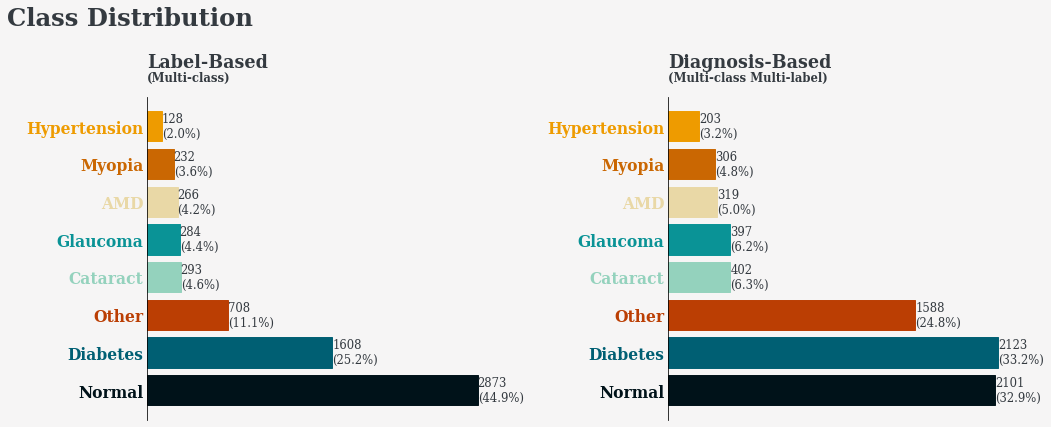

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), dpi=70, gridspec_kw={"wspace": 0.5})

fig.patch.set_facecolor(COLORS["fig_bg"])

value_counts = df_eda["class"].value_counts().rename("num").to_frame()
value_counts["percent"] = value_counts / value_counts.sum()
value_counts.reindex(index=COLORS["class"].keys())

b1 = ax1.barh(value_counts.index, value_counts["percent"])

ax1.set_yticks(
    value_counts.index,
    [class_short2full[i] for i in value_counts.index],
    **FONT_KW["plot_label"], color=COLORS["plot_text"]
)
ax1.tick_params(axis="y", length=0)
ax1.set_title("Label-Based", loc="left", **FONT_KW["subplot_title"], color=COLORS["plot_text"], pad=30)
ax1.text(0, 8.2, "(Multi-class)", **FONT_KW["subplot_title_small"], color=COLORS["plot_text"])

ax1.bar_label(
    b1,
    labels=[str(val) + f"\n({str(np.round(100*pcnt,1))}%)" for val, pcnt in zip(value_counts["num"], value_counts["percent"])],
    color=COLORS["plot_text"],
    **FONT_KW["plot_text"]
)

ax1.set_facecolor(COLORS["fig_bg"])
for i in range(NUM_CLASSES):
    c = COLORS["class"][value_counts.index[i]]
    ax1.get_yticklabels()[i].set_color(c)
    b1[i].set_color(c)

ax1.axes.get_xaxis().set_visible(False)

for spine in ["bottom", "right", "top"]:
    ax1.spines[spine].set_visible(False)


value_count_diag = df_eda[labels_short].sum().rename("num").to_frame()
value_count_diag["percent"] = value_count_diag / df_eda.shape[0]
value_count_diag = value_count_diag.reindex(index=value_counts.index)

b2 = ax2.barh(value_count_diag.index, value_count_diag["percent"])

ax2.set_yticks(
    value_count_diag.index,
    [class_short2full[i] for i in value_count_diag.index],
    **FONT_KW["plot_label"], color=COLORS["plot_text"]
)
ax2.tick_params(axis="y", length=0)
ax2.set_title("Diagnosis-Based", loc="left", **FONT_KW["subplot_title"], color=COLORS["plot_text"], pad=30)
ax2.text(0, 8.2, "(Multi-class Multi-label)", **FONT_KW["subplot_title_small"], color=COLORS["plot_text"])

ax2.bar_label(
    b2,
    labels=[str(val) + f"\n({str(np.round(100*pcnt,1))}%)" for val, pcnt in zip(value_count_diag["num"], value_count_diag["percent"])],
    color=COLORS["plot_text"],
    **FONT_KW["plot_text"]
)

ax2.set_facecolor(COLORS["fig_bg"])
for i in range(NUM_CLASSES):
    c = COLORS["class"][value_count_diag.index[i]]
    ax2.get_yticklabels()[i].set_color(c)
    b2[i].set_color(c)

ax2.axes.get_xaxis().set_visible(False)

for spine in ["bottom", "right", "top"]:
    ax2.spines[spine].set_visible(False)

plt.figtext(0, 1.05, "Class Distribution", **FONT_KW["plot_title"], color=COLORS["plot_text"])

plt.show()

In [ ]:
both_eyes_normal = df_eda[
    (df_eda['Right-Diagnostic Keywords'] == 'normal fundus') &
    (df_eda['Left-Diagnostic Keywords'] == 'normal fundus')
]

both_eyes_normal.reset_index(inplace=True,drop=True)

len(both_eyes_normal)

2002

In [ ]:
both_eyes_not_normal = df_eda[
    (df_eda['Right-Diagnostic Keywords'] != 'normal fundus') &
    (df_eda['Left-Diagnostic Keywords'] != 'normal fundus')
]

both_eyes_not_normal.reset_index(inplace=True,drop=True)

len(both_eyes_not_normal)

2893

In [ ]:
right_eye_normal = df_eda[
    (df_eda['Right-Diagnostic Keywords'] == 'normal fundus') &
    (df_eda['Left-Diagnostic Keywords'] != 'normal fundus')
]

right_eye_normal.reset_index(inplace=True,drop=True)

len(right_eye_normal)

703

In [ ]:
left_eye_normal = df_eda[
    (df_eda['Right-Diagnostic Keywords'] != 'normal fundus') &
    (df_eda['Left-Diagnostic Keywords'] == 'normal fundus')
]

left_eye_normal.reset_index(inplace=True,drop=True)

len(left_eye_normal)

794

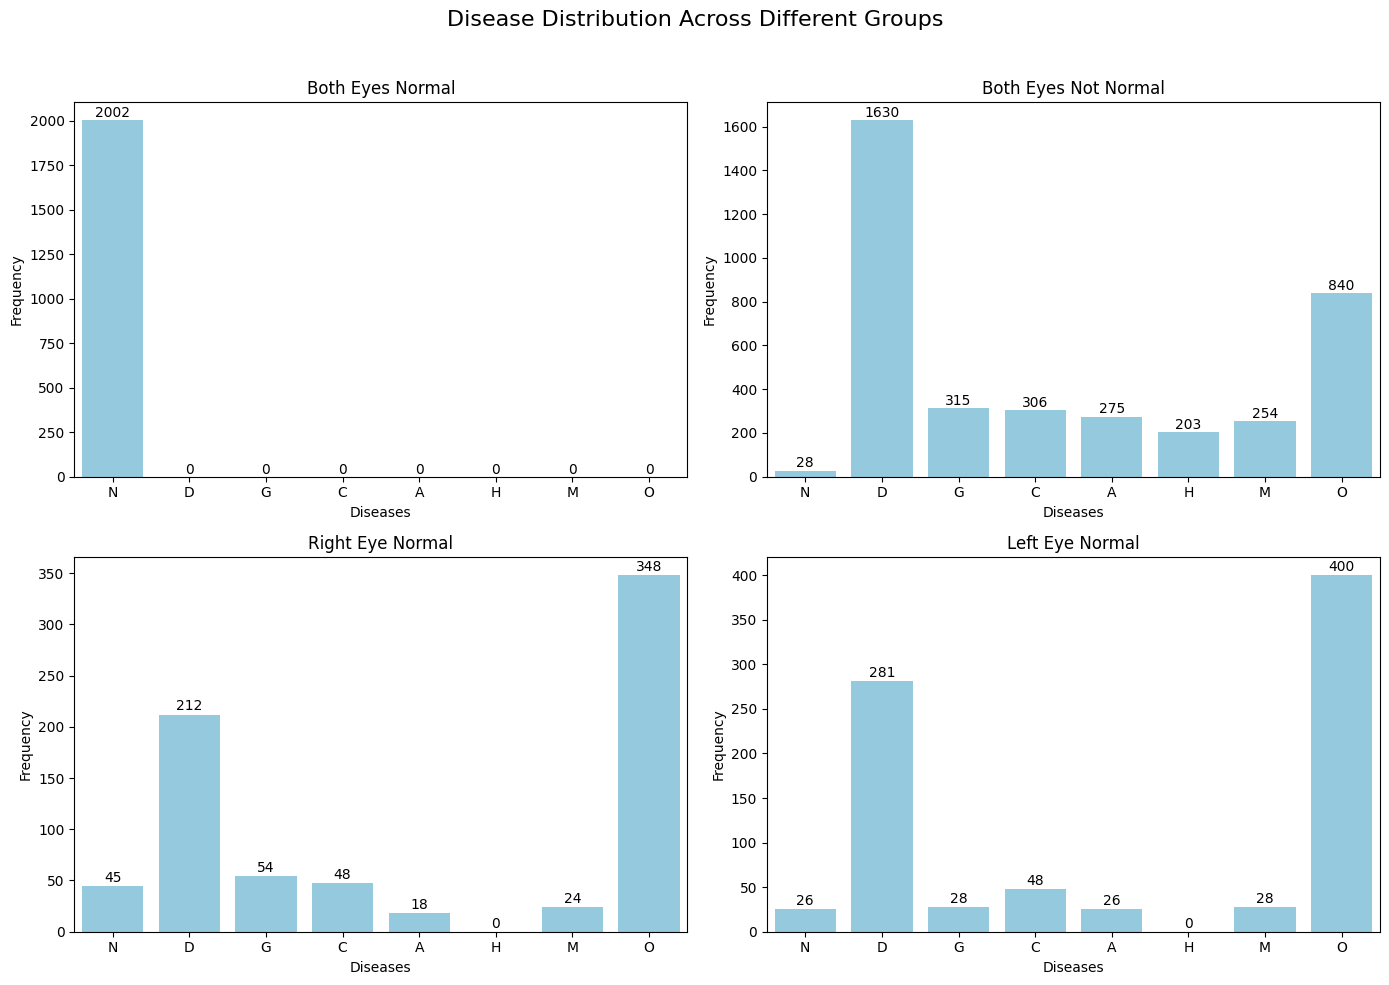

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Disease Distribution Across Different Groups', fontsize=16)

# Define titles for the subplots
titles = [
    'Both Eyes Normal',
    'Both Eyes Not Normal',
    'Right Eye Normal',
    'Left Eye Normal'
]

# Create a list of DataFrames
dataframes = [both_eyes_normal, both_eyes_not_normal, right_eye_normal, left_eye_normal]

# Loop through DataFrames and plot on subplots
for df, ax, title in zip(dataframes, axes.ravel(), titles):
    disease_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    disease_counts = df[disease_columns].sum()

    sns.barplot(x=disease_counts.index, y=disease_counts.values, color='skyblue', ax=ax)

    # Add value labels on top of each bar
    for i, value in enumerate(disease_counts.values):
        ax.text(i, value + 1, str(value), ha='center', va='bottom')

    ax.set_title(title)
    ax.set_xlabel('Diseases')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


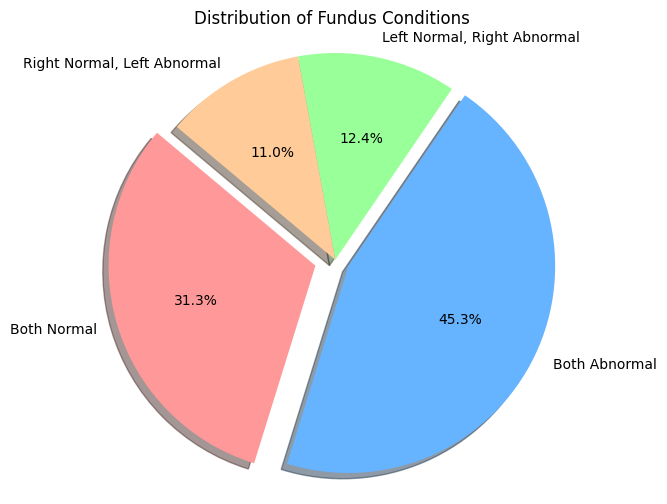

In [ ]:
condition_normal_left = df_eda['Left-Diagnostic Keywords'] == 'normal fundus'
condition_normal_right = df_eda['Right-Diagnostic Keywords'] == 'normal fundus'

# Determine the categories
both_normal = (condition_normal_left) & (condition_normal_right)
both_abnormal = (~condition_normal_left) & (~condition_normal_right)
left_normal_right_abnormal = (condition_normal_left) & (~condition_normal_right)
right_normal_left_abnormal = (~condition_normal_left) & (condition_normal_right)

# Count occurrences for each category
counts = {
    'Both Normal': both_normal.sum(),
    'Both Abnormal': both_abnormal.sum(),
    'Left Normal, Right Abnormal': left_normal_right_abnormal.sum(),
    'Right Normal, Left Abnormal': right_normal_left_abnormal.sum()
}

# Create a pie chart
labels = counts.keys()
sizes = counts.values()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
explode = (0.1, 0.07, 0, 0)  # explode the 1st slice (optional)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Fundus Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

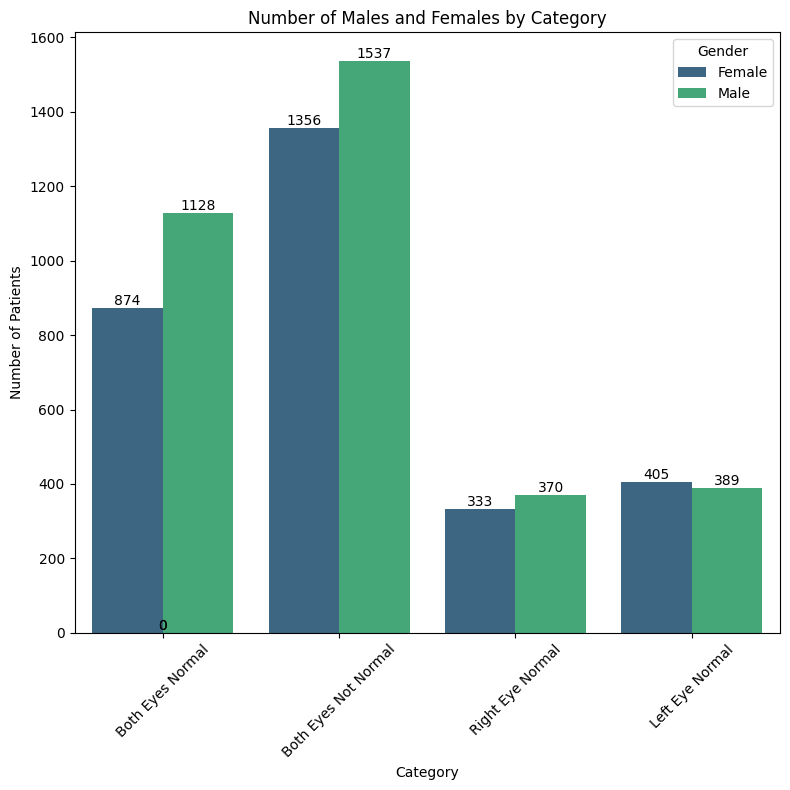

In [ ]:
counts = {
    'Both Eyes Normal': both_eyes_normal['Patient Sex'].value_counts(),
    'Both Eyes Not Normal': both_eyes_not_normal['Patient Sex'].value_counts(),
    'Right Eye Normal': right_eye_normal['Patient Sex'].value_counts(),
    'Left Eye Normal': left_eye_normal['Patient Sex'].value_counts()
}

# Convert to DataFrame for easy plotting
plot_data = pd.DataFrame(counts).fillna(0).T.reset_index()
plot_data = plot_data.melt(id_vars='index', var_name='Gender', value_name='Count')
plot_data = plot_data.rename(columns={'index': 'Category'})

# Create the bar plot
plt.figure(figsize=(8, 8))
sns.barplot(data=plot_data, x='Category', y='Count', hue='Gender', palette='viridis')

plt.title('Number of Males and Females by Category')
plt.xlabel('Category')
plt.ylabel('Number of Patients')
plt.legend(title='Gender')
plt.xticks(rotation=45)

# Get the axis object of the bar chart
ax = plt.gca()

# Get the rectangular object of all columns
bars = ax.patches

# Marks the value in the center of the top of the bar graph
for i, bar in enumerate(bars):
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    ax.text(x, height, str(int(height)), ha='center', va='bottom')

plt.tight_layout()
plt.show()


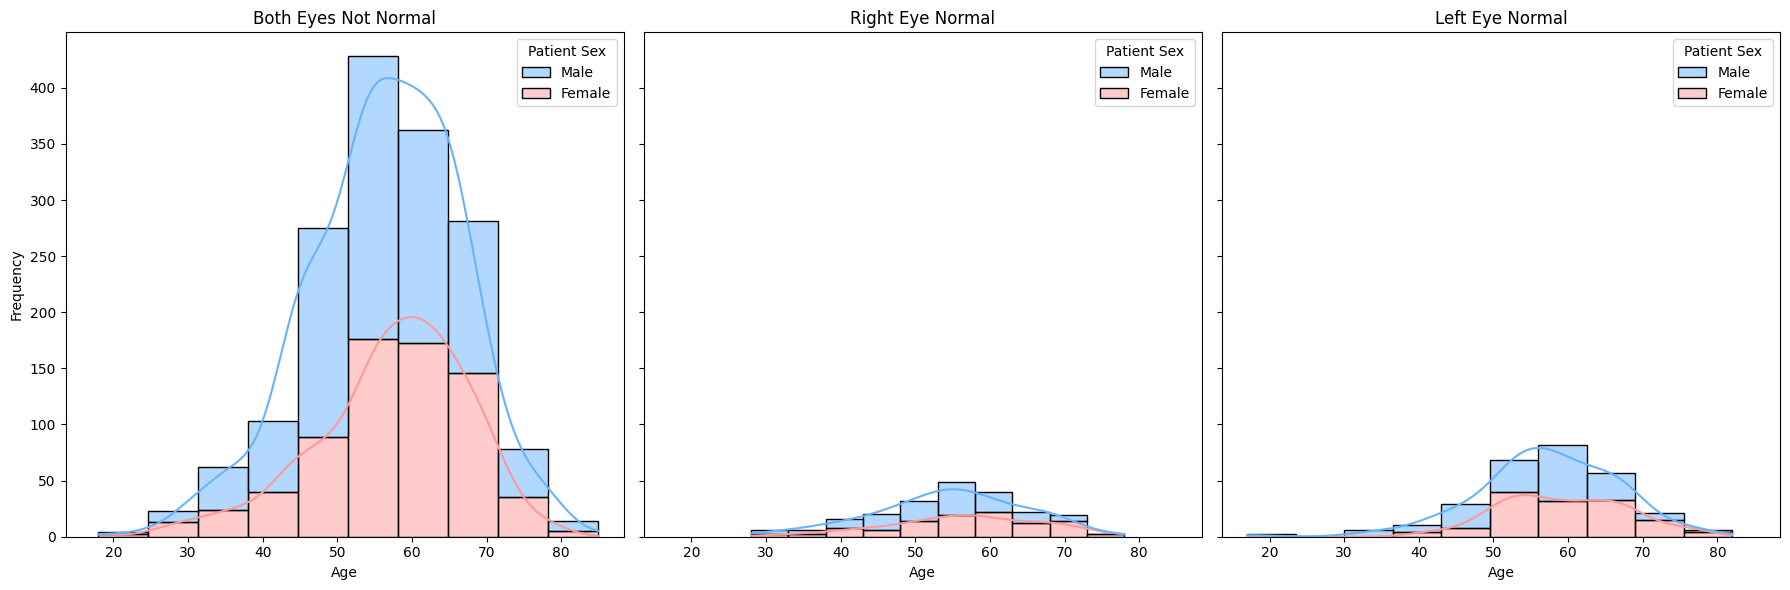

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

dataframes = [both_eyes_not_normal, right_eye_normal, left_eye_normal]

titles = ['Both Eyes Not Normal', 'Right Eye Normal', 'Left Eye Normal']
colors = ['#66b3ff', '#ff9999']

# Plot each dataframe with condition D = 1 applied within the loop
for i, (df, title) in enumerate(zip(dataframes, titles)):
    row = i // 3
    col = i % 3
    filtered_df = df.query('D == 1')
    if not filtered_df.empty:
        sns.histplot(filtered_df, x='Patient Age', hue='Patient Sex', multiple='stack', palette=colors, bins=10, ax=axes[col], kde=True)
    axes[col].set_title(title)
    axes[col].set_xlabel('Age')
    axes[col].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

# **For InceptionV3 model**

In [ ]:
import os
import cv2
import numpy as np
import random
import pandas as pd
from tqdm import tqdm

# Load the CSV file
df = pd.read_csv("/content/drive/MyDrive/archive(V2)/full_df.csv")

# Define the dataset directory
dataset_dir = "/content/drive/MyDrive/archive(V2)/preprocessed_images"  # Replace with the actual dataset directory

# Define all class labels
classes = ['N', 'D', 'G', 'C']  # Class names
class_to_label = {cls: idx for idx, cls in enumerate(classes)}  # Map class names to numeric labels

# Define a function to generate multi-class labels
def get_labels(text):
    labels = []
    for cls in classes:
        if cls in text:  # Check if the class is present in the text
            labels.append(1)
        else:
            labels.append(0)
    return labels

# Generate labels for the left and right eye diagnostic keywords
df["left_labels"] = df["Left-Diagnostic Keywords"].apply(get_labels)
df["right_labels"] = df["Right-Diagnostic Keywords"].apply(get_labels)

# Define a function to create the dataset
def create_dataset(image_category, labels):
    dataset = []
    for img, label in tqdm(zip(image_category, labels)):
        image_path = os.path.join(dataset_dir, img)  # Construct the full image path
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read the image in color mode
            image = cv2.resize(image, (224, 224))  # Resize image to (224, 224) for most models
            dataset.append([np.array(image), np.array(label)])  # Append image and label as a pair
        except:
            continue  # Skip images that cannot be processed
    random.shuffle(dataset)  # Shuffle the dataset for randomness
    return dataset

# Load data for all classes
all_data = []
for cls in classes:
    # Load left eye images for the class
    image_paths = df[df[cls] == 1]['Left-Fundus'].values  # Filter left eye images for the class
    labels = [class_to_label[cls]] * len(image_paths)  # Assign the same label to all images in the class
    print(f"Class {cls}: Number of left eye images: {len(image_paths)}")
    class_data = create_dataset(image_paths, labels)  # Create the dataset for the class
    all_data.extend(class_data)  # Add to the main dataset
    print(f"Class {cls}: Left eye images loaded: {len(class_data)}")

    # Load right eye images for the class
    image_paths = df[df[cls] == 1]['Right-Fundus'].values  # Filter right eye images for the class
    labels = [class_to_label[cls]] * len(image_paths)  # Assign the same label to all images in the class
    print(f"Class {cls}: Number of right eye images: {len(image_paths)}")
    class_data = create_dataset(image_paths, labels)  # Create the dataset for the class
    all_data.extend(class_data)  # Add to the main dataset
    print(f"Class {cls}: Right eye images loaded: {len(class_data)}")

# Print the total size of the dataset
print(f"Total data size: {len(all_data)}")

Class N: Number of left eye images: 2101


497it [05:58,  1.51it/s]

In [ ]:
# Split the dataset
x = np.array([i[0] for i in all_data])
y = np.array([i[1] for i in all_data])

# Check label range
print("Label range:", np.unique(y))
if len(np.unique(y)) != len(classes):
    raise ValueError(f"Number of labels ({len(np.unique(y))}) does not match the number of classes ({len(classes)})!")

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=42)

Label range: [0 1 2 3]


In [ ]:
# Data preprocessing: InceptionV3 requires pixel values to be in the range [0, 255] and uses preprocess_input for normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = preprocess_input(x_train)  # Scale pixel values to [-1, 1]
x_test = preprocess_input(x_test)

In [ ]:
# Apply SMOTE for oversampling (only on training data)
# Flatten image data to apply SMOTE
x_train_shape = x_train.shape
x_train_flat = x_train.reshape(x_train_shape[0], -1)  # Reshape to (number of samples, 224*224*3)
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_flat, y_train)

# Reshape the flattened data back to image shape
x_train_resampled = x_train_resampled.reshape(-1, *x_train_shape[1:])

In [ ]:
# Data augmentation (augment more operations)
datagen = ImageDataGenerator(
    rotation_range=30,         # Increase rotation range
    width_shift_range=0.3,     # Increase horizontal shift range
    height_shift_range=0.3,    # Increase vertical shift range
    horizontal_flip=True,      # Random horizontal flip
    zoom_range=0.2,            # Add zoom
    shear_range=0.2,           # Add shear
    brightness_range=[0.8, 1.2],  # Add brightness adjustment
    fill_mode='nearest'        # Fill mode
)

# Create training data generator
train_generator = datagen.flow(x_train, y_train, batch_size=32)

## **Build InceptionV3 model**

In [ ]:
# Load InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last 10 layers for fine-tuning
for layer in base_model.layers[:-10]:
    layer.trainable = False  # Freeze previous layers
for layer in base_model.layers[-10:]:
    layer.trainable = True   # Unfreeze the last 10 layers

# Build the model (Round 2: 3 fully connected layers)
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))  # Reduce the number of neurons to lower the risk of overfitting
model.add(BatchNormalization())  # Add a Batch Normalization layer
model.add(Dropout(0.3))  # Reduce the Dropout rate
model.add(Dense(256, activation='relu'))  # Second fully connected layer
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))  # Third fully connected layer (reduce the number of neurons)
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(len(classes), activation='softmax'))  # Output layer

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,080,484 (339.82 MB)

 Trainable params: 67,276,100 (256.64 MB)

 Non-trainable params: 21,804,384 (83.18 MB)


## **Evaluate InceptionV3 model**

33epoch stop, accuracy about 45%

In [ ]:
# Calculate class weights to address class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Add learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,              # Use data augmentation for training data
    epochs=50,                    # Set more epochs, early stopping will automatically control
    validation_data=(x_test, y_test),  # Use the test set as the validation set
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weights_dict  # Add class weights
)
model.save('model_InceptionV3.h5')  # Save in HDF5 format
print("The model has been saved completely as InceptionV3.h5")

Class weights: {0: np.float64(0.5956034482758621), 1: np.float64(0.5933527997251804), 2: np.float64(3.1692660550458718), 3: np.float64(3.1234177215189876)}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 228s 952ms/step - accuracy: 0.3329 - loss: 1.6682 - val_accuracy: 0.5149 - val_loss: 1.0689 - learning_rate: 1.0000e-04
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 172s 796ms/step - accuracy: 0.3738 - loss: 1.4178 - val_accuracy: 0.4882 - val_loss: 1.1986 - learning_rate: 1.0000e-04
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 171s 790ms/step - accuracy: 0.3999 - loss: 1.3398 - val_accuracy: 0.4845 - val_loss: 1.1441 - learning_rate: 1.0000e-04
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 168s 778ms/step - accuracy: 0.4062 - loss: 1.2673 - val_accuracy: 0.4588 - val_loss: 1.2612 - learning_rate: 1.0000e-04
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 167s 773ms/step - accuracy: 0.3974 - loss: 1.2830 - val_accuracy: 0.4966 - val_loss: 1.1456 - learning_rate: 1.0000e-04
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 165s 764ms/step - accuracy: 0.4322 - loss: 1.2152 - val_accuracy: 0.4990 - val_loss: 1.1448 - learning_rate: 1.0000e-04
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 

模型已完整保存为 my_model.h5


**Evaluate Model and Visualize Results**

93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.5106 - loss: 1.0943
Test accuracy: 0.5149
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 181ms/step
Example of true labels: [0 0 1 1 3 1 1 0 0 0]
Example of predicted labels: [3 0 0 1 3 1 1 2 0 1]


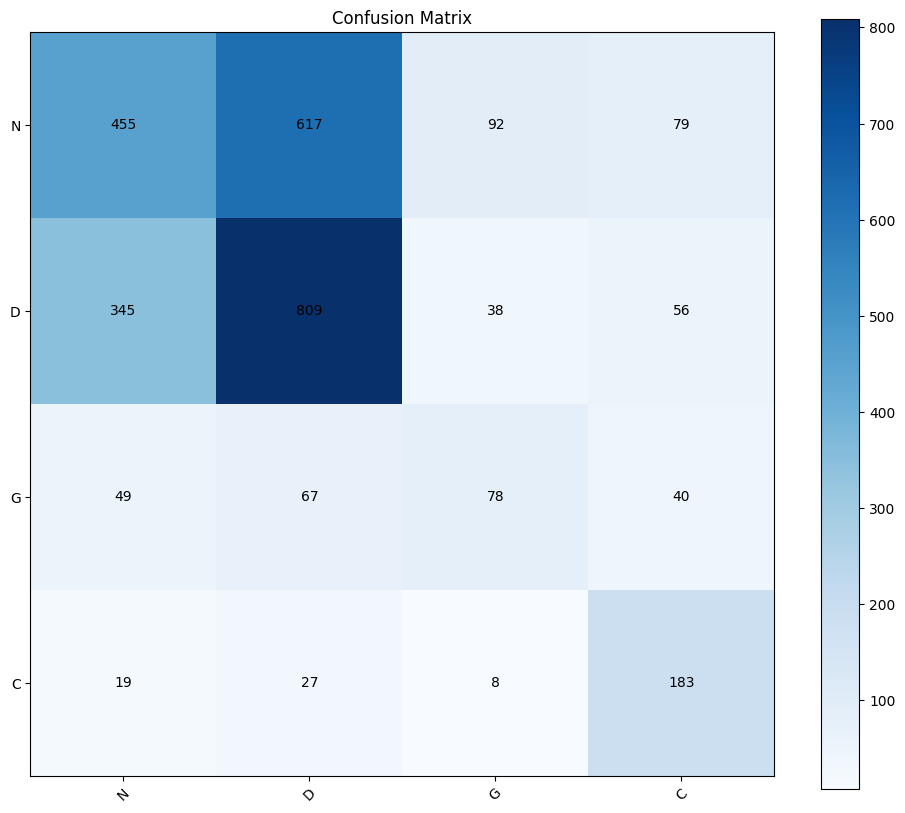

              precision    recall  f1-score   support

           N       0.52      0.37      0.43      1243
           D       0.53      0.65      0.58      1248
           G       0.36      0.33      0.35       234
           C       0.51      0.77      0.62       237

    accuracy                           0.51      2962
   macro avg       0.48      0.53      0.49      2962
weighted avg       0.51      0.51      0.50      2962



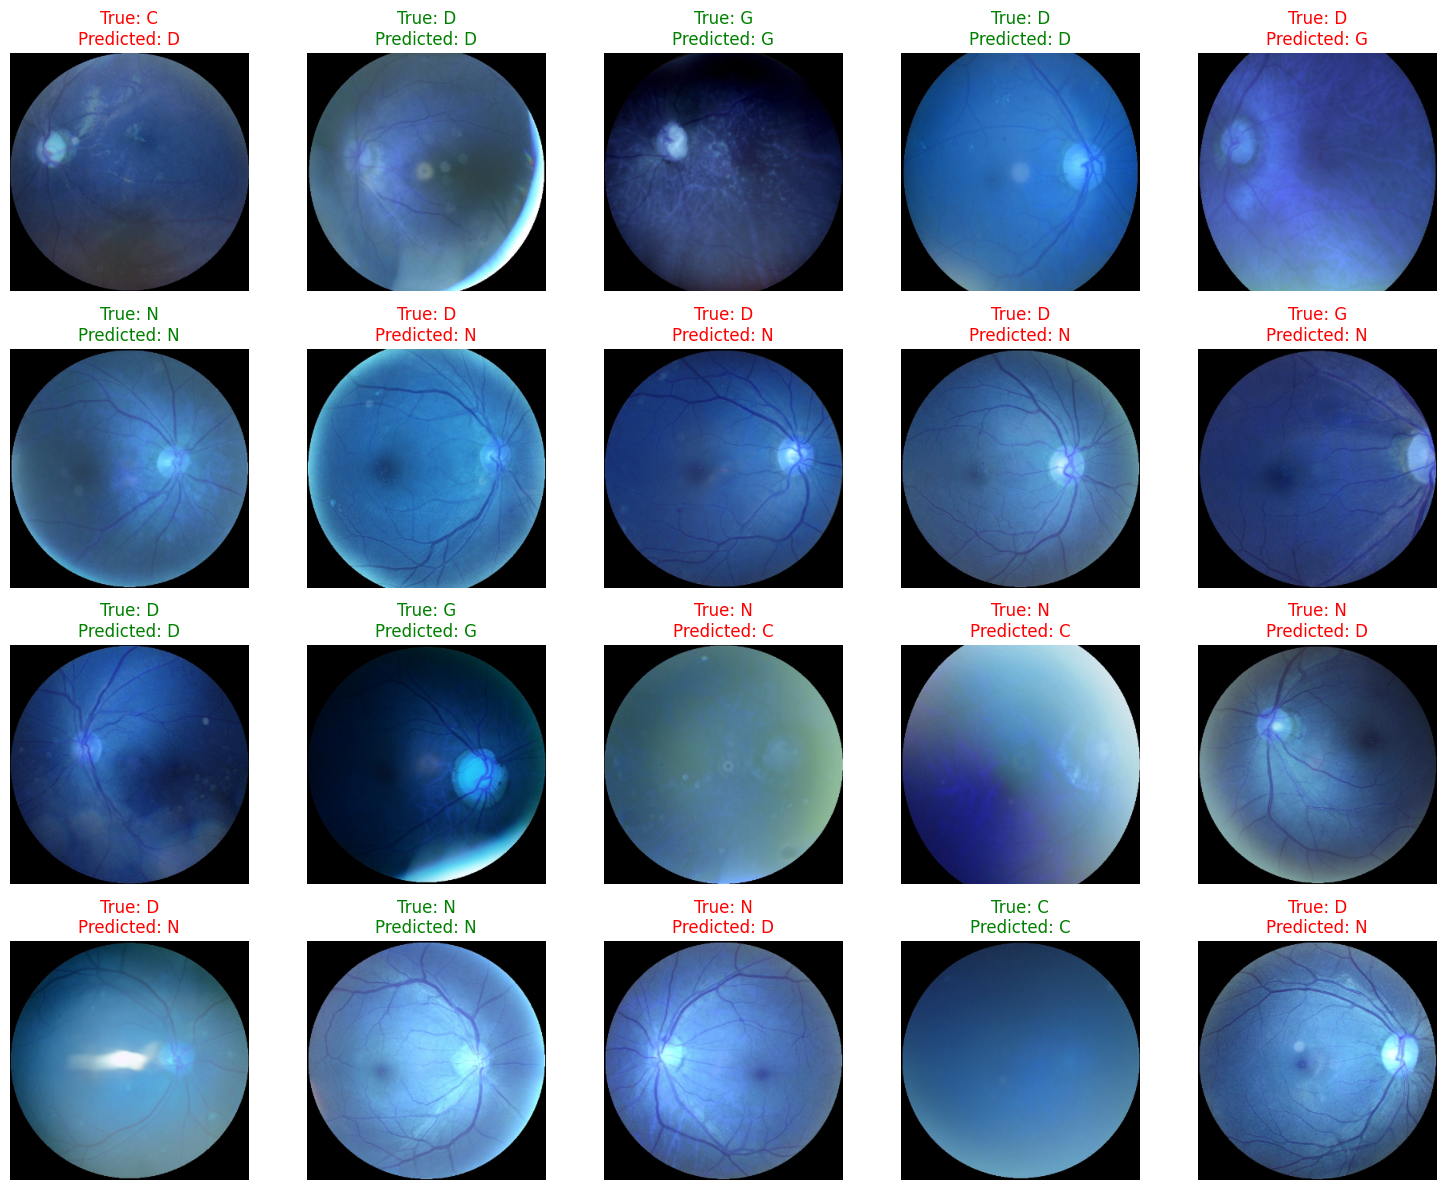

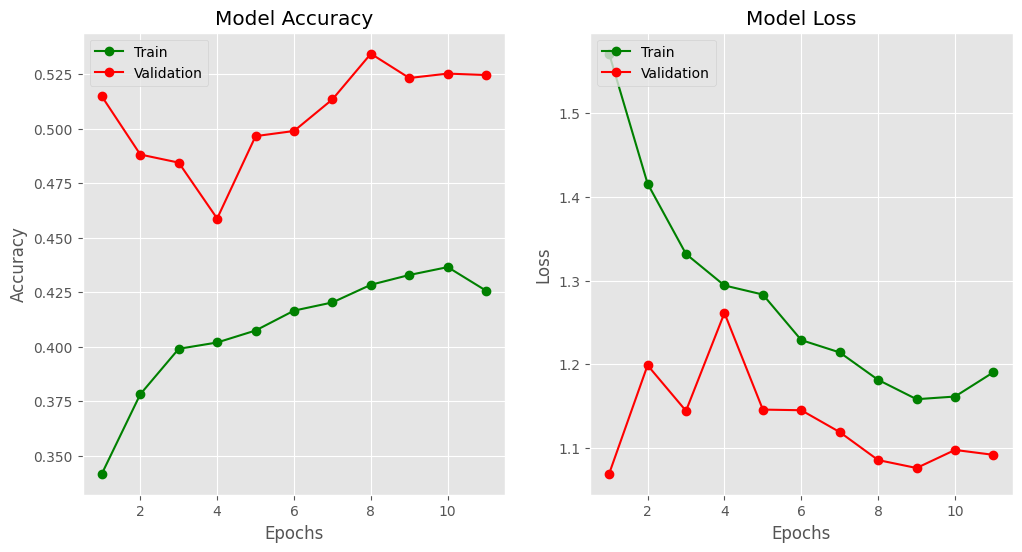

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')

# Make predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Check prediction results
print("Example of true labels:", y_test[:10])
print("Example of predicted labels:", y_pred_classes[:10])

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add numerical labels to the confusion matrix
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=classes))

# Visualization of predictions
plt.figure(figsize=(15, 12))
for i in range(20):
    idx = random.randint(0, len(x_test) - 1)
    image = x_test[idx]
    true_label = classes[y_test[idx]]
    pred_label = classes[y_pred_classes[idx]]

    plt.subplot(4, 5, i + 1)
    # Reverse image preprocessing for correct display (because preprocess_input changed pixel values)
    image_display = (image + 1) * 127.5  # Convert [-1, 1] back to [0, 255]
    image_display = np.clip(image_display, 0, 255).astype(np.uint8)
    plt.imshow(image_display)
    plt.title(f'True: {true_label}\nPredicted: {pred_label}',
              color='green' if true_label == pred_label else 'red')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Plot accuracy and loss curves during training
plt.style.use("ggplot")
fig = plt.figure(figsize=(12, 6))
epochs = range(1, len(history.history['accuracy']) + 1)
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [ ]:
# import gc
# import tensorflow as tf
# del model
# del x_test, y_test, train_generator  # Delete the used data variable
# tf.keras.backend.clear_session()
# tf.compat.v1.reset_default_graph()

# gc.collect()

0


# **For Efficient model**

**Import data**

In [ ]:
from pathlib import Path

In [ ]:
import os
import shutil
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define source and target paths
source_dir = '/content/drive/My Drive/archive(V2)/preprocessed_images'
target_dir = '/content/drive/My Drive/archive/preprocessed_images'

# Check if the source path exists
if not os.path.exists(source_dir):
    raise FileNotFoundError(f"Source path does not exist: {source_dir}")

# Handle the case where the target path already exists (Optional: delete first or overwrite directly)
if os.path.exists(target_dir):
    # Be careful! Confirm the target folder contents can be overwritten before deleting
    shutil.rmtree(target_dir)
    print(f"Existing target folder deleted: {target_dir}")

# Copy the folder (recursively copy all contents)
try:
    shutil.copytree(source_dir, target_dir)
    print(f"Folder copied successfully to target path: {target_dir}")
except Exception as e:
    print(f"Error encountered during copying: {str(e)}")

# Verify the copy operation (check the number of files)
def count_files(folder):
    return sum(len(files) for _, _, files in os.walk(folder))

source_file_count = count_files(source_dir)
target_file_count = count_files(target_dir)

if source_file_count == target_file_count:
    print(f"Verification successful: Source file count {source_file_count} vs Target file count {target_file_count}")
else:
    print(f"Verification failed: File counts do not match (Source: {source_file_count}, Target: {target_file_count})")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
文件夹复制完成，目标路径: /content/drive/My Drive/archive/preprocessed_images
验证通过：源文件数6392 vs 目标文件数6392


**Visualize an image**

Random image path: /content/drive/My Drive/archive/preprocessed_images/1490_left.jpg
Image class: preprocessed_images
Image height: 512
Image width: 512


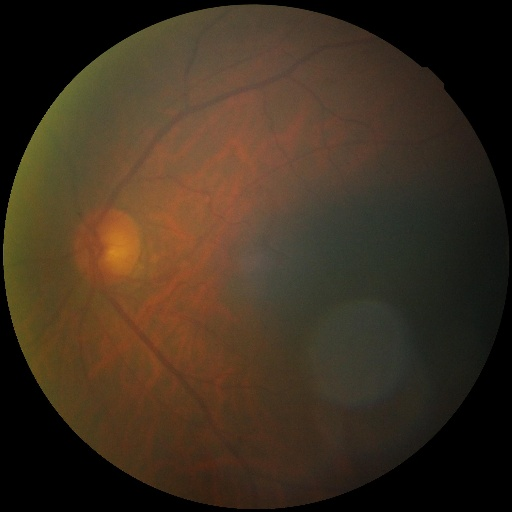

In [ ]:
import random
from PIL import Image
# Setting the data path
image_path = Path('/content/drive/My Drive/archive/preprocessed_images') #This path is the path of the new dataset

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

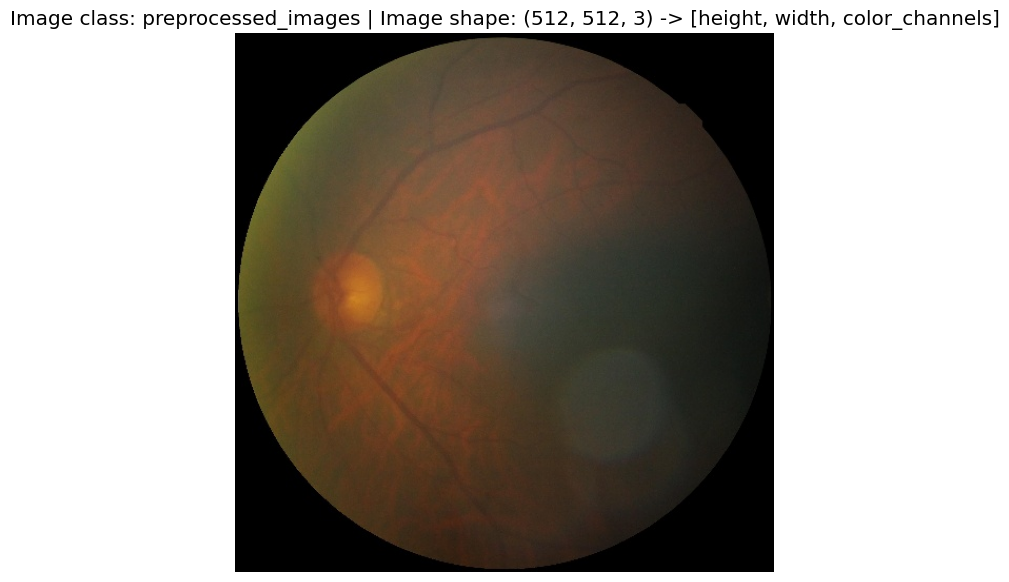

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

##**Transforming data**

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# Write transform for image
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

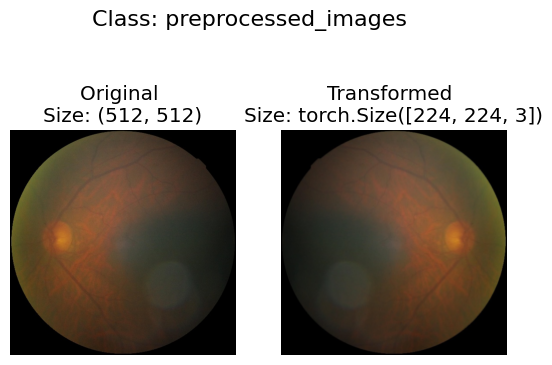

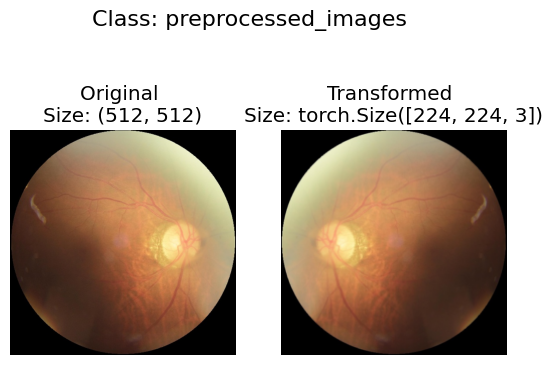

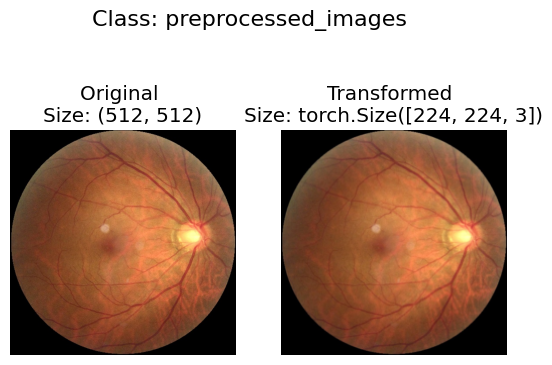

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

In [ ]:
import pandas as pd

# Read the Excel file
xlsx_path = "data.xlsx"  # Ensure the path is spelled correctly
df = pd.read_excel(xlsx_path)  # Replace with the path to your Excel file

# Display the data
print(df.head())

   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   3           66        Male  3_left.jpg  3_right.jpg   
4   4           53        Male  4_left.jpg  4_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                                      normal fundus   
4                        macular epiretinal membrane   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  
0                           normal fundus  0  0  0  1  0  0  0  0  
1                           normal fundus  1  0  0  0  0  0  0  0  
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1  
3         branch retinal artery occl

In [ ]:
import os
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil

# Define the class labels
classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Define dataset paths
preprocessed_dir = '/content/drive/MyDrive/archive/preprocessed_images'
train_dir = '/content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images'
test_dir = '/content/drive/MyDrive/aritifical intelligent/ODIR/New Testing Images'
excel_path = 'data.xlsx'

# Create category folders for the new training and testing datasets
def create_category_folders(base_dir):
    base_dir = Path(base_dir)
    for cls in classes:
        (base_dir / cls).mkdir(parents=True, exist_ok=True)

create_category_folders(train_dir)
create_category_folders(test_dir)

# Split dataset and organize images by category
def split_and_organize_images(preprocessed_dir, train_dir, test_dir, excel_path, test_size=0.2):
    """
    Split preprocessed images into training and testing datasets, and store them by category.

    Args:
        preprocessed_dir (str): Directory containing all preprocessed images.
        train_dir (str): Base directory for the new training dataset.
        test_dir (str): Base directory for the new testing dataset.
        excel_path (str): Path to the Excel file containing class labels.
        test_size (float): Proportion of the dataset to include in the test split.
    """
    # Read the Excel file
    df = pd.read_excel(excel_path)

    # Initialize lists to store image paths and labels
    image_paths = []
    image_labels = []

    # Iterate through each row in the Excel file
    for _, row in df.iterrows():
        left_image = row["Left-Fundus"]
        right_image = row["Right-Fundus"]
        left_labels = row[classes].values.tolist()  # Multi-class labels for the left eye
        right_labels = row[classes].values.tolist()  # Multi-class labels for the right eye

        # Add left eye image path and labels
        image_paths.append(os.path.join(preprocessed_dir, left_image))
        image_labels.append(left_labels)

        # Add right eye image path and labels
        image_paths.append(os.path.join(preprocessed_dir, right_image))
        image_labels.append(right_labels)

    # Split into training and testing datasets
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        image_paths, image_labels, test_size=test_size, random_state=42
    )

    # Move images to the corresponding category folders
    def move_images_to_category(paths, labels, base_dir):
        for img_path, label in zip(paths, labels):
            if not os.path.exists(img_path):  # Skip if the image does not exist
                print(f"Warning: {img_path} does not exist.")
                continue

            # Move the image to the corresponding category folder
            for cls, is_present in zip(classes, label):
                if is_present == 1:  # If the class label is 1, classify the image into that category
                    dest_dir = os.path.join(base_dir, cls)
                    shutil.copy(img_path, dest_dir)  # Copy the image to the destination folder
                    print(f"Moved {img_path} to {dest_dir}")
                    break  # An image can only belong to one category

    # Organize training images
    print("Organizing training images...")
    move_images_to_category(train_paths, train_labels, train_dir)

    # Organize testing images
    print("Organizing testing images...")
    move_images_to_category(test_paths, test_labels, test_dir)

# Call the function to split and organize the dataset
split_and_organize_images(preprocessed_dir, train_dir, test_dir, excel_path)

In [ ]:
from pathlib import Path

def check_images_in_categories(data_dir):
    """
    Check if each category folder contains image files.
    Args:
        data_dir (str): Path to the root directory of the dataset
    """
    data_dir = Path(data_dir)
    for category in data_dir.iterdir():
        if category.is_dir():  # Only check directories
            images = list(category.glob("*.jpg"))  # Look for .jpg files
            print(f"Category: {category.name}, Images: {len(images)}")
            if len(images) > 0:
                print(f"  Example image: {images[0].name}")

# Check training and testing datasets
print("Checking training images:")
check_images_in_categories(train_dir)

print("\nChecking testing images:")
check_images_in_categories(test_dir)

Checking training images:
Category: N, Images: 1689
  Example image: 2566_left.jpg
Category: D, Images: 1696
  Example image: 4312_right.jpg
Category: G, Images: 283
  Example image: 1212_right.jpg
Category: C, Images: 255
  Example image: 2221_right.jpg
Category: A, Images: 224
  Example image: 1869_left.jpg
Category: H, Images: 69
  Example image: 62_left.jpg
Category: M, Images: 202
  Example image: 771_right.jpg
Category: O, Images: 694
  Example image: 517_left.jpg

Checking testing images:
Category: N, Images: 412
  Example image: 2798_left.jpg
Category: D, Images: 427
  Example image: 4400_left.jpg
Category: G, Images: 58
  Example image: 1277_left.jpg
Category: C, Images: 67
  Example image: 2167_left.jpg
Category: A, Images: 43
  Example image: 1830_left.jpg
Category: H, Images: 18
  Example image: 777_left.jpg
Category: M, Images: 55
  Example image: 382_right.jpg
Category: O, Images: 200
  Example image: 1028_left.jpg


In [ ]:
import os

def check_image_extensions(directory):
    supported_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}
    for root, _, files in os.walk(directory):
        for file in files:
            ext = os.path.splitext(file)[-1].lower()  # Get the file extension
            if ext not in supported_extensions:
                print(f"Unsupported file: {os.path.join(root, file)}")

# Check the training and testing directories
check_image_extensions('/content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images')
check_image_extensions('/content/drive/MyDrive/aritifical intelligent/ODIR/New Testing Images')

In [ ]:
import os

def check_folder_structure(directory):
    for root, dirs, files in os.walk(directory):
        print(f"Directory: {root}")
        print(f"  Subfolders: {dirs}")
        print(f"  Files: {files[:5]}{'...' if len(files) > 5 else ''}")  # Display only the first 5 files

# Check the training and testing folder structure
print("Training directory structure:")
check_folder_structure('/content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images')

print("\nTesting directory structure:")
check_folder_structure('/content/drive/MyDrive/aritifical intelligent/ODIR/New Testing Images')

Training directory structure:
Directory: /content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images
  Subfolders: ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
  Files: []
Directory: /content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images/N
  Subfolders: []
  Files: ['2566_left.jpg', '3294_right.jpg', '3124_left.jpg', '2697_right.jpg', '3227_right.jpg']...
Directory: /content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images/D
  Subfolders: []
  Files: ['4312_right.jpg', '1488_right.jpg', '4630_left.jpg', '4445_right.jpg', '466_right.jpg']...
Directory: /content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images/G
  Subfolders: []
  Files: ['1212_right.jpg', '1277_right.jpg', '1213_left.jpg', '1431_left.jpg', '1408_left.jpg']...
Directory: /content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images/C
  Subfolders: []
  Files: ['2221_right.jpg', '2112_left.jpg', '2170_left.jpg', '2136_left.jpg', '2113_left.jpg']...
Directory: /cont

In [ ]:
print(f"Training directory: {train_dir}")
print(f"Testing directory: {test_dir}")

Training directory: /content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images
Testing directory: /content/drive/MyDrive/aritifical intelligent/ODIR/New Testing Images


In [ ]:
from torchvision import datasets
from torchvision import transforms

# Data preprocessing
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Check paths
train_dir = '/content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images'
test_dir = '/content/drive/MyDrive/aritifical intelligent/ODIR/New Testing Images'

# Load training and testing datasets
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f"Train data size: {len(train_data)} images")
print(f"Test data size: {len(test_data)} images")
print(f"Classes: {train_data.classes}")
print(f"Classes: {test_data.classes}")

Train data size: 5112 images
Test data size: 1280 images
Classes: ['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']
Classes: ['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']


In [ ]:
# Inherit and override the `find_classes` method of the ImageFolder class
from torchvision.datasets import ImageFolder
import os

class FilteredImageFolder(ImageFolder):
    def __init__(self, root, allowed_classes, transform=None, is_valid_file=None):
        self.allowed_classes = allowed_classes
        super().__init__(root, transform=transform, is_valid_file=is_valid_file)

    def find_classes(self, directory):
        # Only return the allowed classes
        classes = [d.name for d in os.scandir(directory) if d.is_dir() and d.name in self.allowed_classes]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

# Your data paths and preprocessing
train_dir = '/content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images'
test_dir = '/content/drive/MyDrive/aritifical intelligent/ODIR/New Testing Images'

data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

allowed_classes = ['N', 'D', 'G', 'C']

train_data = FilteredImageFolder(root=train_dir, allowed_classes=allowed_classes, transform=data_transform)
test_data = FilteredImageFolder(root=test_dir, allowed_classes=allowed_classes, transform=data_transform)

print(f"Train data size: {len(train_data)} images")
print(f"Test data size: {len(test_data)} images")
print(f"Classes: {train_data.classes}")
print(f"Classes: {test_data.classes}")

Train data size: 3923 images
Test data size: 964 images
Classes: ['C', 'D', 'G', 'N']
Classes: ['C', 'D', 'G', 'N']


In [ ]:
from torchvision import datasets
from torchvision import transforms

# Data preprocessing
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor()          # Convert to tensor
])

# Load training and testing datasets
train_data = FilteredImageFolder(root=train_dir, allowed_classes=allowed_classes, transform=data_transform)
test_data = FilteredImageFolder(root=test_dir, allowed_classes=allowed_classes, transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

# Check classes
print(f"Classes: {train_data.classes}")  # Print the list of classes

Train data:
Dataset FilteredImageFolder
    Number of datapoints: 3923
    Root location: /content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset FilteredImageFolder
    Number of datapoints: 964
    Root location: /content/drive/MyDrive/aritifical intelligent/ODIR/New Testing Images
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Classes: ['C', 'D', 'G', 'N']


In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['C', 'D', 'G', 'N']

In [ ]:
# Check the lengths
len(train_data), len(test_data)

(3923, 964)

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Image shape: torch.Size([3, 224, 224])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


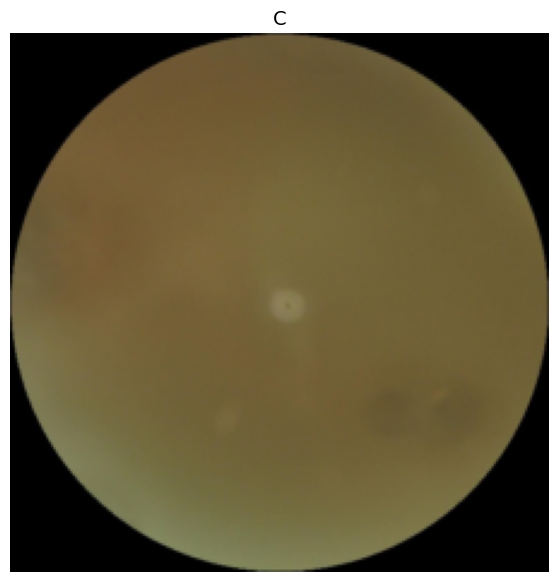

In [ ]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e28bc6f8510>,
 <torch.utils.data.dataloader.DataLoader at 0x7e2a35deef10>)

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [ ]:
from typing import List

In [ ]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


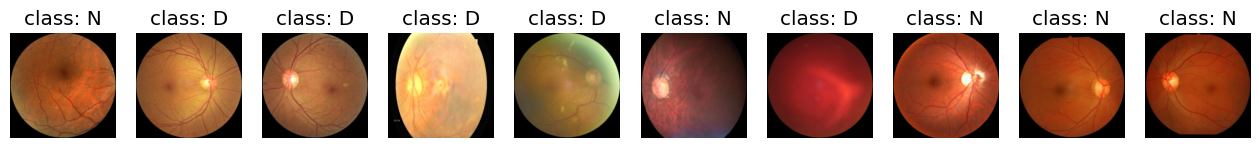

In [ ]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=12,
                      classes=class_names,
                      seed=None)

##**Turn loaded images into DataLoader's**

In [ ]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data, # use custom created test Dataset
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7e28bc6efcd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e2a35b17810>)

In [ ]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [ ]:
import torch
import torch.nn as nn
import torch

# Check if a GPU is available, use it if available, otherwise use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
# Turn image folders into Datasets
train_data_augmented = FilteredImageFolder(train_dir, allowed_classes=allowed_classes, transform=train_transform_trivial_augment)
test_data_simple = FilteredImageFolder(test_dir, allowed_classes=allowed_classes, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset FilteredImageFolder
     Number of datapoints: 3923
     Root location: /content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset FilteredImageFolder
     Number of datapoints: 964
     Root location: /content/drive/MyDrive/aritifical intelligent/ODIR/New Testing Images
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [ ]:
print(f"Train data root: {train_data_augmented.root}")
print(f"Test data root: {test_data_simple.root}")

Train data root: /content/drive/MyDrive/aritifical intelligent/ODIR/New Training Images
Test data root: /content/drive/MyDrive/aritifical intelligent/ODIR/New Testing Images


In [ ]:
print(f"Number of training samples: {len(train_data_augmented)}")
print(f"Number of testing samples: {len(test_data_simple)}")

Number of training samples: 3923
Number of testing samples: 964


In [ ]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e28bcad43d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e2a35deef10>)

## Build Efficient model

In [ ]:
# pip install timm

In [ ]:
import torch
import torch.nn as nn
from timm import create_model

In [ ]:
class EfficientNetModified(nn.Module):
    """
    EfficientNet-based model.
    Replacing TinyVGG with EfficientNet while retaining the structure of the original code.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

In [ ]:
# Create model_2 and send it to the target device
torch.manual_seed(42)
model_2 = EfficientNetModified(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_2

EfficientNetModified(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=4, bias=True)
  )
)

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

about 12 mins, accuracy about 50%

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_2
model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1132 | train_acc: 0.4105 | test_loss: 1.0642 | test_acc: 0.4170
Epoch: 2 | train_loss: 1.0880 | train_acc: 0.4654 | test_loss: 1.0627 | test_acc: 0.4580
Epoch: 3 | train_loss: 1.0894 | train_acc: 0.4586 | test_loss: 1.0549 | test_acc: 0.4756
Epoch: 4 | train_loss: 1.0838 | train_acc: 0.4685 | test_loss: 1.0419 | test_acc: 0.5029
Epoch: 5 | train_loss: 1.0828 | train_acc: 0.4688 | test_loss: 1.0352 | test_acc: 0.4756
Epoch: 6 | train_loss: 1.0807 | train_acc: 0.4757 | test_loss: 1.0323 | test_acc: 0.5088
Epoch: 7 | train_loss: 1.0736 | train_acc: 0.4786 | test_loss: 1.0255 | test_acc: 0.4980
Epoch: 8 | train_loss: 1.0715 | train_acc: 0.4860 | test_loss: 1.0182 | test_acc: 0.5371
Epoch: 9 | train_loss: 1.0709 | train_acc: 0.4910 | test_loss: 1.0331 | test_acc: 0.4814
Epoch: 10 | train_loss: 1.0673 | train_acc: 0.4904 | test_loss: 1.0150 | test_acc: 0.5088
Epoch: 11 | train_loss: 1.0718 | train_acc: 0.4808 | test_loss: 1.0146 | test_acc: 0.5176
Epoch: 12 | train_l

In [ ]:

torch.save(model_2, "model_Efficient.pth")

## **Evaluate** Efficient model

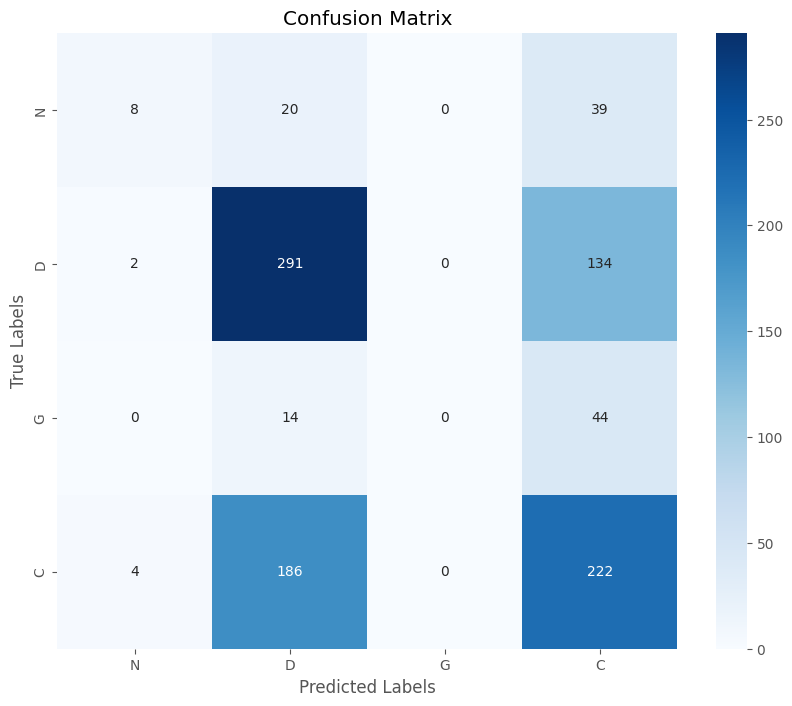

Classification Report:
              precision    recall  f1-score   support

           N       0.57      0.12      0.20        67
           D       0.57      0.68      0.62       427
           G       0.00      0.00      0.00        58
           C       0.51      0.54      0.52       412

    accuracy                           0.54       964
   macro avg       0.41      0.33      0.33       964
weighted avg       0.51      0.54      0.51       964


Detailed Metrics:
N: Precision=0.5714, Recall=0.1194, F1-Score=0.1975, Support=67
D: Precision=0.5695, Recall=0.6815, F1-Score=0.6205, Support=427
G: Precision=0.0000, Recall=0.0000, F1-Score=0.0000, Support=58
C: Precision=0.5057, Recall=0.5388, F1-Score=0.5217, Support=412

Overall Accuracy: 0.5405

Summary:
Macro Average: Precision=0.4116, Recall=0.3349, F1-Score=0.3349
Weighted Average: Precision=0.5081, Recall=0.5405, F1-Score=0.5115


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
import torch
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support,
    accuracy_score,
)
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix and output performance metrics
def evaluate_and_report_metrics(model, dataloader, class_names, device="cuda"):
    """
    Evaluate the model, plot the confusion matrix, and output metrics such as Accuracy, Precision, Recall, F1-Score.

    Args:
        model (torch.nn.Module): The trained model.
        dataloader (DataLoader): Test dataset dataloader.
        class_names (list): List of class names.
        device (str): Device type ("cuda" or "cpu").
    """
    model.eval()  # Set the model to evaluation mode
    y_true = []  # Store true labels
    y_pred = []  # Store predicted labels

    # Disable gradient calculation to speed up inference
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)  # Move data to GPU or CPU
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)  # Get predicted classes

            y_true.extend(labels.cpu().numpy())  # Collect true labels
            y_pred.extend(predictions.cpu().numpy())  # Collect predicted labels

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Visualize the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Output the classification report (Precision, Recall, F1-Score)
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Calculate Precision, Recall, and F1-Score for each class
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

    # Output Precision, Recall, and F1-Score for each class
    print("\nDetailed Metrics:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1-Score={f1[i]:.4f}, Support={support[i]}")

    # Calculate and output overall accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    # Output macro and weighted averages for the metrics
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    print("\nSummary:")
    print(f"Macro Average: Precision={precision_macro:.4f}, Recall={recall_macro:.4f}, F1-Score={f1_macro:.4f}")
    print(f"Weighted Average: Precision={precision_weighted:.4f}, Recall={recall_weighted:.4f}, F1-Score={f1_weighted:.4f}")

# Assuming your class names are as follows
class_names = ['N', 'D', 'G', 'C']

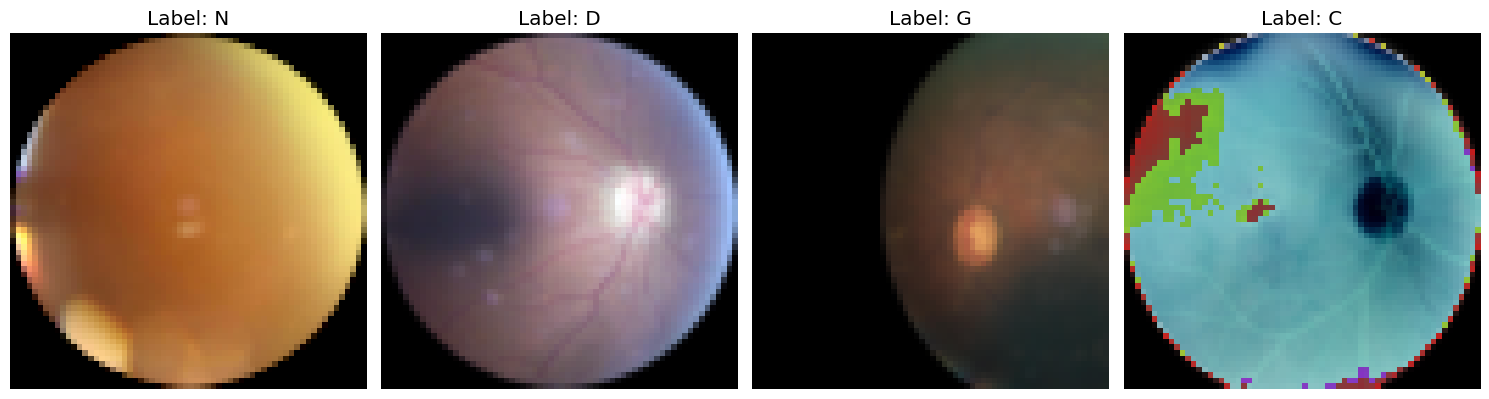

In [ ]:
import matplotlib.pyplot as plt

# Display images for each class
def plot_images_by_classes(dataloader, class_names, num_classes=8):
    """
    Display one image per class from the data loader.

    Args:
        dataloader (DataLoader): The data loader.
        class_names (list): List of class names.
        num_classes (int): Number of classes.
    """
    images_shown = [False] * num_classes  # Flags to track if an image for each class has been shown
    plt.figure(figsize=(15, 10))  # Set the canvas size

    # Iterate through the data loader
    for images, labels in dataloader:
        for img, label in zip(images, labels):
            label = label.item()  # Get the class index
            if not images_shown[label]:  # If an image for this class hasn't been shown yet
                images_shown[label] = True
                plt.subplot(2, 4, label + 1)  # Create a subplot (2 rows, 4 columns)
                plt.imshow(img.permute(1, 2, 0))  # Rearrange dimensions for display
                plt.title(f"Label: {class_names[label]}")
                plt.axis("off")  # Hide the axis

            # Exit once all classes have been displayed
            if all(images_shown):
                break
        if all(images_shown):
            break

    plt.tight_layout()
    plt.show()

# Assuming your class names are as follows
class_names = ['N', 'D', 'G', 'C']

# Call the function to display images
plot_images_by_classes(train_dataloader_augmented, class_names)

#**For VGG model**

In [ ]:
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/archive(V2)/full_df.csv")
df.head(3)

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   

                     target     filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg  
2  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg

In [ ]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg16 import VGG16 as vgg
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

# Define dataset directory
dataset_dir = "/content/drive/MyDrive/archive(V2)/preprocessed_images"  # Replace with the actual dataset directory

# Define all class labels
classes = ['N', 'D', 'G', 'C']
class_to_label = {cls: idx for idx, cls in enumerate(classes)}

# Modify the label generation function
def get_labels(text):
    labels = []
    for cls in classes:
        if cls in text:
            labels.append(1)
        else:
            labels.append(0)
    return labels

# Generate multi-class labels
df["left_labels"] = df["Left-Diagnostic Keywords"].apply(get_labels)
df["right_labels"] = df["Right-Diagnostic Keywords"].apply(get_labels)

# Modify the dataset creation function
def create_dataset(image_category, labels):
    dataset = []
    for img, label in tqdm(zip(image_category, labels)):
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (224, 224))
            dataset.append([np.array(image), np.array(label)])
        except:
            continue
    random.shuffle(dataset)
    return dataset

# Load data for all classes
all_data = []
for cls in classes:
    image_paths = df[df[cls] == 1][f'Left-Fundus'].values
    labels = [class_to_label[cls]] * len(image_paths)
    print(f"Class {cls}: Left images found: {len(image_paths)}")
    class_data = create_dataset(image_paths, labels)
    all_data.extend(class_data)
    print(f"Class {cls}: Left images loaded: {len(class_data)}")

    image_paths = df[df[cls] == 1][f'Right-Fundus'].values
    labels = [class_to_label[cls]] * len(image_paths)
    print(f"Class {cls}: Right images found: {len(image_paths)}")
    class_data = create_dataset(image_paths, labels)
    all_data.extend(class_data)
    print(f"Class {cls}: Right images loaded: {len(class_data)}")

print(f"Total data loaded: {len(all_data)}")

Class N: Left images found: 2101


2101it [00:10, 202.60it/s]


Class N: Left images loaded: 2071
Class N: Right images found: 2101


2101it [00:10, 197.42it/s]


Class N: Right images loaded: 2072
Class D: Left images found: 2123


2123it [00:10, 198.09it/s]


Class D: Left images loaded: 2080
Class D: Right images found: 2123


2123it [00:10, 197.87it/s]


Class D: Right images loaded: 2079
Class G: Left images found: 397


397it [00:01, 203.28it/s]


Class G: Left images loaded: 389
Class G: Right images found: 397


397it [00:01, 207.82it/s]


Class G: Right images loaded: 390
Class C: Left images found: 402


402it [00:02, 188.89it/s]


Class C: Left images loaded: 394
Class C: Right images found: 402


402it [00:02, 197.68it/s]

Class C: Right images loaded: 396
Total data loaded: 9871


*italicized text*> 30% acc

In [ ]:
# Build a Multi-Class Classification Model
model = Sequential()
model.add(vgg(include_top=False, input_shape=(224, 224, 3)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

# Compile the Model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
x = np.array([i[0] for i in all_data])
y = np.array([i[1] for i in all_data])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)


##**Build VGG model**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

# Load VGG16 and unfreeze some layers
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
for layer in vgg.layers[:-4]:
    layer.trainable = False
for layer in vgg.layers[-4:]:
    layer.trainable = True

# Build the model
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(len(classes), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compute class weights (if needed)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
# Define Callbacks
checkpoint = ModelCheckpoint('model_VGG.h5', monitor='val_accuracy', save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=5)

# Train the Model
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=20,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint, earlystop])

NameError: name 'model' is not defined

##**Evaluate VGG model**

62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.8763 - loss: 0.5023
Test accuracy: 0.8729
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step


([<matplotlib.axis.YTick at 0x7e2b0deee350>,
 [Text(0, 0, 'N'), Text(0, 1, 'D'), Text(0, 2, 'G'), Text(0, 3, 'C')])

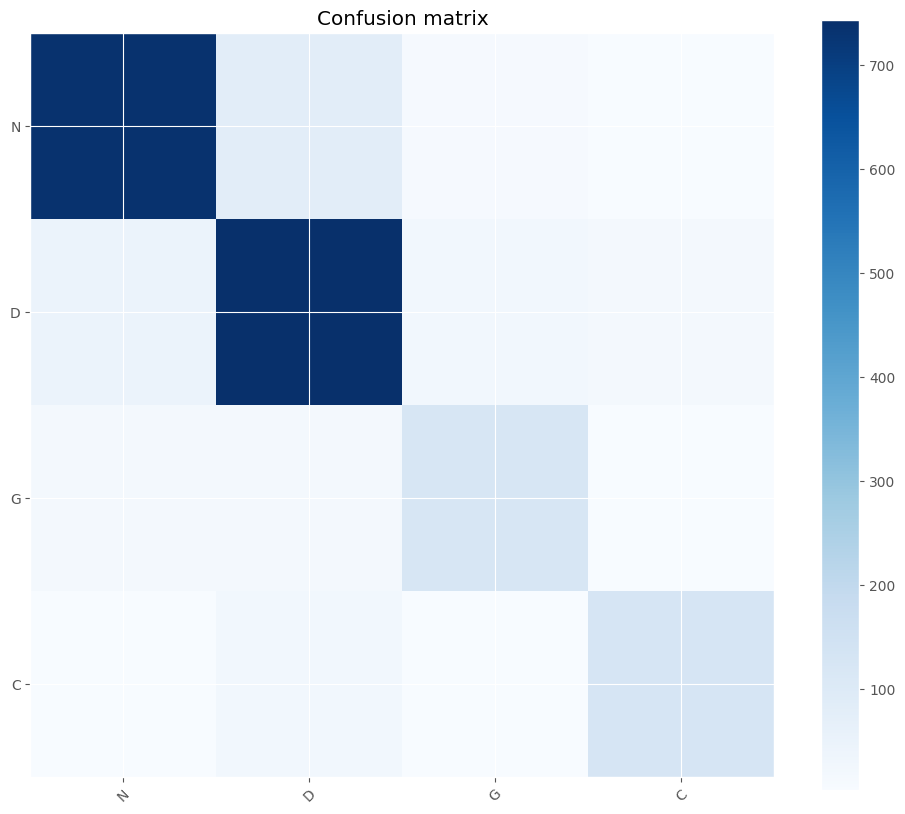

In [ ]:
# Evaluation
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')

# Prediction
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(12,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

In [ ]:
# Classification Report
print(classification_report(y_test, y_pred_classes, target_names=classes))

# Prediction Visualization
plt.figure(figsize=(15,12))
for i in range(20):
    idx = random.randint(0, len(x_test)-1)
    image = x_test[idx]
    true_label = classes[y_test[idx]]
    pred_label = classes[y_pred_classes[idx]]

              precision    recall  f1-score   support

           N       0.92      0.89      0.90       829
           D       0.86      0.89      0.88       832
           G       0.76      0.76      0.76       156
           C       0.83      0.79      0.81       158

    accuracy                           0.87      1975
   macro avg       0.84      0.83      0.84      1975
weighted avg       0.87      0.87      0.87      1975



<Figure size 1500x1200 with 0 Axes>

#**Model validation and Amazon deployment**

## Environment configuration: Supports debugging in both local and AWS modes.

In [ ]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 129.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 8.5 MB/s eta 0:00:00


In [ ]:
!pip install llama-cpp-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 MB 34.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.8 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.8-cp311-cp311-linux_x86_64.whl size=6007964 sha256=04b328fdc35dd5c9cb5ac52b600c6eb92cb5ff7bd213a8316de5b1a0deb69549
  Stored in directory: /root/.cache/pip/wheels/c0/03/66/eb3810eafd55d921b2be32896d1f44313996982360663aa80b
Successfully built llama-cpp-python


In [ ]:
!wget https://huggingface.co/TheBloke/medicine-LLM-13B-GGUF/resolve/main/medicine-llm-13b.Q4_K_M.gguf

--2025-04-17 04:06:25--  https://huggingface.co/TheBloke/medicine-LLM-13B-GGUF/resolve/main/medicine-llm-13b.Q4_K_M.gguf
Resolving huggingface.co (huggingface.co)... 13.35.202.121, 13.35.202.34, 13.35.202.40, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.121|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/20/b7/20b71c67dca735c784f567d56bdb814884398667a558360577e9d506c87920a6/2e4451109aed59cf3052fb71d150ce521aac24452f44b218c48e3a5b3cc51939?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27medicine-llm-13b.Q4_K_M.gguf%3B+filename%3D%22medicine-llm-13b.Q4_K_M.gguf%22%3B&Expires=1744866385&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NDg2NjM4NX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzIwL2I3LzIwYjcxYzY3ZGNhNzM1Yzc4NGY1NjdkNTZiZGI4MTQ4ODQzOTg2NjdhNTU4MzYwNTc3ZTlkNTA2Yzg3OTIwYTYvMmU0NDUxMTA5YWVkNTljZjMwNTJmYjcxZDE1MGNlNTIxYWFjMjQ0NTJmND

Deploying Using SageMaker Console

Upload model files to an S3 bucket
Create a model in SageMaker Console:
Navigate to "SageMaker" > "Models"
Click "Create model"
Specify model name and IAM role
For container definition, select appropriate framework (TensorFlow/PyTorch) and version
Provide model location (S3 path)
Provide inference script path (if required)
Create endpoint configuration:
Navigate to "SageMaker" > "Endpoint configurations"
Click "Create endpoint configuration"
Specify configuration name
Add model and set instance type/quantity
Create endpoint:
Navigate to "SageMaker" > "Endpoints"
Click "Create endpoint"
Select the newly created endpoint configuration

In [ ]:
import torch
import boto3
import pandas as pd
from PIL import Image
import numpy as np
from torchvision import transforms
import tensorflow as tf
from llama_cpp import Llama
import json
import time
import torch.nn as nn
from torch.serialization import add_safe_globals
import os


# Read data
df = pd.read_csv("/content/drive/MyDrive/archive(V2)/full_df.csv")
row = df.iloc[0]


base_image_path = "/content/drive/MyDrive/archive/preprocessed_images/"

left_image_path = [os.path.join(base_image_path, row["Left-Fundus"])]
right_image_path = [os.path.join(base_image_path, row["Right-Fundus"])]

sample_data = {
    "ID": int(row["ID"]),
    "Age": [int(row["Patient Age"])],
    "Sex": [row["Patient Sex"]],
    "LeftImagePath": [os.path.join(base_image_path, row["Left-Fundus"])],
    "RightImagePath": [os.path.join(base_image_path, row["Right-Fundus"])],
    # Symptom Generation (Incorporating Cataract Description)
    "LeftSymptoms": [
        "Painless progressive vision decline for 1 year, lens opacity, with significantly worse vision under bright light."  # left error
    ],
    "RightSymptoms": [
        "Fundus examination of the right eye showed no abnormalities, with clear retinal structures."  # right normal
    ]
}
df = df.head(1)
print(json.dumps(sample_data, indent=2, ensure_ascii=False))


DEPLOY_MODE = os.getenv("DEPLOY_MODE", "local")
LLM_MODEL_PATH = os.getenv("LLM_MODEL_PATH", "medicine-llm-13b.Q4_K_M.gguf")
SAGEMAKER_IMAGE_ENDPOINT = os.getenv("SAGEMAKER_IMAGE_ENDPOINT", "ocular-image-endpoint")
AWS_LLM_MODEL = os.getenv("AWS_LLM_MODEL", "anthropic.claude-v2")

LOCAL_MODEL_CONFIG = {
    "h5": ["model_VGG.h5"],
    "pth": ["model_Efficient.pth"],
    "llm_gguf": LLM_MODEL_PATH
}

DISEASE_CLASSES = ['N', 'D', 'G', 'C']
IMAGE_SIZE = (224, 224)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if DEPLOY_MODE == "sagemaker":
    sagemaker_runtime = boto3.client("sagemaker-runtime", region_name="us-east-1")
    bedrock = boto3.client("bedrock-runtime", region_name="us-east-1")



{
  "ID": 0,
  "Age": [
    69
  ],
  "Sex": [
    "Female"
  ],
  "LeftImagePath": [
    "/content/drive/MyDrive/archive/preprocessed_images/0_left.jpg"
  ],
  "RightImagePath": [
    "/content/drive/MyDrive/archive/preprocessed_images/0_right.jpg"
  ],
  "LeftSymptoms": [
    "Painless progressive vision decline for 1 year, lens opacity, with significantly worse vision under bright light."
  ],
  "RightSymptoms": [
    "Fundus examination of the right eye showed no abnormalities, with clear retinal structures."
  ]
}


LLM Module (Clinical Text Analysis)

In [ ]:

class LLMHandler:
    def __init__(self):
        self.deploy_mode = DEPLOY_MODE
        if self.deploy_mode == "local":
            self._load_local_llm()
        else:
            self.aws_llm_model = AWS_LLM_MODEL

    def _load_local_llm(self):
        self.llm = Llama(
            model_path=LOCAL_MODEL_CONFIG["llm_gguf"],
            n_gpu_layers=-1,
            temperature=0.1,
            verbose=False,
            n_ctx=2048
        )

    def get_clinical_judgment(self, prompt):
        if self.deploy_mode == "local":
            response = self.llm(prompt=prompt, max_tokens=1, stop=["\n"])
            return response["choices"][0]["text"].strip().upper() or "N"
        else:
            return self._invoke_aws_llm(prompt, "judgment")

    def generate_medical_advice(self, prompt):
        if self.deploy_mode == "local":
            response = self.llm(prompt=prompt, max_tokens=300, stop=["\n\n"])
            return response["choices"][0]["text"].strip()
        else:
            return self._invoke_aws_llm(prompt, "advice")

    def _invoke_aws_llm(self, prompt, task):
        body = json.dumps({
            "prompt": prompt,
            "modelId": self.aws_llm_model,
            "maxTokens": 300 if task == "advice" else 1,
            "temperature": 0.1
        })
        response = bedrock.invoke_model(
            body=body,
            modelId=self.aws_llm_model,
            accept="application/json",
            contentType="application/json"
        )
        return json.loads(response["body"].read())["completion"].strip()


class EfficientNetWrapper(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        from torchvision.models import efficientnet_b0
        base_model = efficientnet_b0(weights=None)

        in_features = base_model.classifier[1].in_features
        base_model.classifier[1] = nn.Linear(in_features, num_classes)

        self.model = base_model

    def forward(self, x):
        return self.model(x)

## Loading imaging model

In [ ]:

class ImageModelHandler:
    def __init__(self, base_image_path: str):
        self.base_image_path = base_image_path
        self.local_models = self._load_local_models()

    def _load_local_models(self) -> list[dict]:
        models = []

        if LOCAL_MODEL_CONFIG["pth"]:
            try:
                for pth_path in LOCAL_MODEL_CONFIG["pth"]:

                    model = EfficientNetWrapper(num_classes=4)

                    state_dict = torch.load(pth_path, map_location=DEVICE)
                    model.load_state_dict(state_dict)

                    model.eval().to(DEVICE)

                    models.append({
                        "model": model,
                        "transform": self._get_pt_transform(),
                        "name": "EfficientNet",
                        "device": DEVICE,
                        "format": "pth"
                    })
            except Exception as e:
                pass

        if LOCAL_MODEL_CONFIG["h5"]:
            for h5_path in LOCAL_MODEL_CONFIG["h5"]:
                try:
                    model = tf.keras.models.load_model(h5_path)
                    models.append({
                        "model": model,
                        "transform": self._get_h5_transform(),
                        "name": "VGG",
                        "format": "h5"
                    })
                except Exception as e:
                    pass

        return models

    def _get_pt_transform(self) -> transforms.Compose:
        return transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _get_h5_transform(self) -> tf.keras.Sequential:

        return tf.keras.Sequential([
            tf.keras.layers.Resizing(*IMAGE_SIZE),
            tf.keras.layers.Rescaling(1. / 255),
            tf.keras.layers.Lambda(lambda x: tf.image.resize(x, IMAGE_SIZE))
        ])

    def predict_image(self, model_config: dict, image_filename: str) -> dict:
        image_path = os.path.join(self.base_image_path, image_filename)
        img = Image.open(image_path).convert("RGB")
        if model_config["format"] == "pth":
            return self._predict_pth_model(model_config, img)
        elif model_config["format"] == "h5":
            return self._predict_h5_model(model_config, img)
        else:
            raise ValueError(f"unsuppurt: {model_config['format']}")

    def _predict_pth_model(self, model_config: dict, img: Image) -> dict:
        img_tensor = model_config["transform"](img).unsqueeze(0).to(model_config["device"])
        with torch.no_grad():
            outputs = model_config["model"](img_tensor)
            prob = torch.nn.functional.softmax(outputs, dim=1).squeeze().cpu().numpy()
        return self._format_prediction(prob, model_config["name"])

    def _predict_h5_model(self, model_config: dict, img: Image) -> dict:
        img_array = np.array(img)
        img_tensor = model_config["transform"](img_array)[np.newaxis, ...]
        try:
            predictions = model_config["model"].predict(img_tensor)
        except Exception as e:
            print(f"vgg error: {e}")
            return None
        return self._format_prediction(predictions[0], model_config["name"])

    def _format_prediction(self, probabilities: np.ndarray, model_name: str) -> dict:
        idx = np.argmax(probabilities)
        return {
            "disease": DISEASE_CLASSES[idx],
            "confidence": float(probabilities[idx]),
            "model_name": model_name,
            "all_scores": {cls: float(score) for cls, score in zip(DISEASE_CLASSES, probabilities)}
        }

## Case processing

In [ ]:

class CaseProcessor:
    def __init__(self, df: pd.DataFrame, base_image_path: str):
        self.df = df
        self.image_handler = ImageModelHandler(base_image_path)
        self.llm_handler = LLMHandler()
        self._validate_data_format()

    def _validate_data_format(self):
        required_columns = ["ID", "Patient Age", "Patient Sex", "Left-Fundus", "Right-Fundus"]
        missing_cols = [col for col in required_columns if col not in self.df.columns]
        if missing_cols:
            raise ValueError(f"loss columns: {missing_cols}")

    def process_case(self, index: int) -> dict:
        row = self.df.iloc[index]
        patient_info = self._get_patient_info(row)
        image_results = self._predict_both_eyes(row)
        if any(result is None for result in image_results):
            print("image error")
            return None
        llm_input = self._build_llm_prompt(patient_info, image_results)

        return {
            "patient_info": patient_info,
            "image_diagnosis": image_results,
            "llm_clinical_judgment": self.llm_handler.get_clinical_judgment(llm_input),
            "medical_advice": self.llm_handler.generate_medical_advice(llm_input)
        }

    def _get_patient_info(self, row: pd.Series) -> dict:
        return {
            "patient_id": int(row["ID"]),
            "age": int(row["Patient Age"]),
            "sex": row["Patient Sex"],
            "left_symptom": row.get("Left-Diagnostic Keywords", ""),
            "right_symptom": row.get("Right-Diagnostic Keywords", "")
        }

    def _predict_both_eyes(self, row: pd.Series) -> list[dict]:
        results = []
        for eye, filename in [("Left", row["Left-Fundus"]), ("Right", row["Right-Fundus"])]:
            for model in self.image_handler.local_models:
                pred = self.image_handler.predict_image(model, filename)
                if pred is not None:
                    pred["eye"] = eye
                    results.append(pred)
        return results

    def _build_llm_prompt(self, patient_info: dict, image_results: list[dict]) -> str:
          prompt = f"Patient ID: {patient_info['patient_id']}\n"
          prompt += f"Age: {patient_info['age']} Gender: {patient_info['sex']}\n"
          prompt += f"Left eye symptoms: {patient_info['left_symptom']}\n"
          prompt += f"Right eye symptoms: {patient_info['right_symptom']}\n\n"
          prompt += "Imaging model diagnostic results:\n"
          for result in image_results:
              prompt += f"- {result['model_name']}({result['eye']} eye): {result['disease']} (Confidence: {result['confidence'] * 100:.2f}%)\n"
          prompt += "\nPlease provide clinical diagnostic suggestions based on the above information:"
          return prompt

## Diagnostic case example

In [ ]:
    processor = CaseProcessor(df, base_image_path)

    for idx in df.index:
        start_time = time.time()
        result = processor.process_case(idx)
        if result is not None:
            patient_info = result["patient_info"]
            image_diagnosis = result["image_diagnosis"]
            clinical_judgment = result["llm_clinical_judgment"]
            medical_advice = result["medical_advice"]

            diagnosis_report = f"Diagnostic Report\n\n"
            diagnosis_report += f"Patient ID: {patient_info['patient_id']}\n"
            diagnosis_report += f"Age: {patient_info['age']} Gender: {patient_info['sex']}\n"
            diagnosis_report += f"Left eye symptoms: {patient_info['left_symptom']}\n"
            diagnosis_report += f"Right eye symptoms: {patient_info['right_symptom']}\n\n"
            diagnosis_report += "Imaging model diagnostic results:\n"
            for img_result in image_diagnosis:
                diagnosis_report += f"- {img_result['model_name']}({img_result['eye']} eye): {img_result['disease']} (Confidence: {img_result['confidence'] * 100:.2f}%)\n"
            diagnosis_report += f"\nClinical diagnosis: {clinical_judgment}\n"
            diagnosis_report += f"\nMedical advice: {medical_advice}\n"

            print(diagnosis_report)
        end_time = time.time()
        print(f"Processing time: {end_time - start_time} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Diagnostic Report

Patient ID: 0
Age: 69 Gender: Female
Left eye symptoms: cataract
Right eye symptoms: normal fundus

Imaging model diagnostic results:
- VGG(Left eye): G (Confidence: 67.69%)
- VGG(Right eye): G (Confidence: 64.41%)

Clinical diagnosis: N

Medical advice: Based on the above information, it seems that the patient is experiencing symptoms related to a cataract in the left eye. The VGG model has provided diagnostic results for both eyes, indicating that the right eye appears to be normal with a high level of confidence, while the left eye has a lower level of confidence.

Processing time: 44.44553279876709 seconds
